<a href="https://colab.research.google.com/github/ziatdinovmax/FerroSim/blob/master/Examples/FerroSim_GP_v2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian process-based optimization of material for optimal response

April 24, 2020


- FerroSIM package by *Rama K. Vasudevan*
- GPim package by *Maxim Ziatdinov*
- Workflow by *Sergei V. Kalinin*

In [1]:
#@title Installations
!pip install git+https://github.com/ramav87/FerroSim.git
!pip install gpim

  Cloning https://github.com/ramav87/FerroSim.git to /private/var/folders/mq/byjy7ljx4pbbp_8j306fqpg00000gp/T/pip-req-build-wnzuy5uh
  Running command git clone -q https://github.com/ramav87/FerroSim.git /private/var/folders/mq/byjy7ljx4pbbp_8j306fqpg00000gp/T/pip-req-build-wnzuy5uh
  on a case-insensitive filesystem) and only one from the same
  colliding group is in the working tree:

    'README.MD'
    'README.md'
  Created wheel for FerroSim: filename=FerroSim-0.0.1-py3-none-any.whl size=6060 sha256=bff5cdad2403c51b479e4f5b0fc011963020d20339b046bc2a9de46dcebf8462
  Stored in directory: /private/var/folders/mq/byjy7ljx4pbbp_8j306fqpg00000gp/T/pip-ephem-wheel-cache-5b4qks97/wheels/1b/6c/66/4f3b4b62e25663f8940610948ba1c50c1f9eca3e76e13db967
Successfully built FerroSim
     |████████████████████████████████| 119.6 MB 25 kB/s  eta 0:00:01     |████████████████████████████▊   | 107.3 MB 634 kB/s eta 0:00:20
     |████████████████████████████████| 634 kB 1.6 MB/s eta 0:00:01
     |██████

Imports:

In [2]:
from ferrosim import Ferro2DSim
import gpim
import numpy as np
import matplotlib.pyplot as plt

We start by plotting loops as a function of parameters and vizualize the depolarization factor effects.

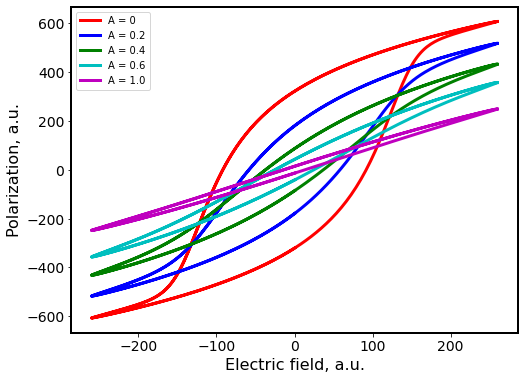

In [3]:
# Depolarization factor effects
loop_t_arr = np.zeros((874))
for tt in range (0,100,10):
    sim = Ferro2DSim(
        n=10, defect_number=0, rfield_strength=0,
        rTip=3, t_max=1, E_frac=300)
    sim.dep_alpha = 0.02*tt
    results = sim.runSim()
    loop_t_arr = np.vstack((loop_t_arr, sim.results['Polarization'][126:]))

# Plot results
plt.figure(figsize=(8,6))
plt.plot(sim.appliedE[125:], loop_t_arr[1,:], 'r-', lw=3, label='A = 0')
plt.plot(sim.appliedE[125:], loop_t_arr[2,:], 'b-', lw=3, label='A = 0.2')
plt.plot(sim.appliedE[125:], loop_t_arr[3,:], 'g-', lw=3, label='A = 0.4')
plt.plot(sim.appliedE[125:], loop_t_arr[4,:], 'c-', lw=3, label='A = 0.6')
plt.plot(sim.appliedE[125:], loop_t_arr[6,:], 'm-', lw=3, label='A = 1.0')
plt.tick_params(labelsize = 14)
plt.legend()

ax = plt.gca()
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)

plt.xlabel('Electric field, a.u.', fontsize=16)
plt.ylabel('Polarization, a.u.', fontsize=16)

plt.show()

Now plot evolution of the loops as a function of the defect concentration:

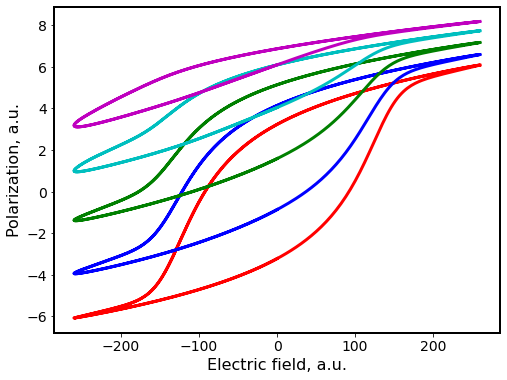

In [4]:
loop_t_arr = np.zeros((874))
for tt in range (0,100,20):
    #k1 = 0.2*tt
    k1 = 1
    defect_number = 5*tt
    sim = Ferro2DSim(
        n=20, k=k1, defect_number=defect_number,
        rfield_strength=1000, rTip=3, t_max=1, E_frac=300)
    sim.dep_alpha = 0.0
    results = sim.runSim()
    loop_t_arr = np.vstack((loop_t_arr, sim.results['Polarization'][126:]/(20**2)))

# plot results
plt.figure(figsize = (8,6))
plt.plot(sim.appliedE[125:],loop_t_arr[1,:], 'r-', lw = 3)
plt.plot(sim.appliedE[125:],loop_t_arr[2,:], 'b-', lw = 3)
plt.plot(sim.appliedE[125:],loop_t_arr[3,:], 'g-', lw = 3)
plt.plot(sim.appliedE[125:],loop_t_arr[4,:], 'c-', lw = 3)
plt.plot(sim.appliedE[125:],loop_t_arr[5,:], 'm-', lw = 3)
plt.tick_params(labelsize = 14)

ax = plt.gca()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlabel('Electric field, a.u.', fontsize=16)
plt.ylabel('Polarization, a.u.', fontsize=16)

plt.show()

Now we will explore responses as a function of model parameters.

In [5]:
def quality_func(def_num, random_field):
  sim = Ferro2DSim(n = 10, defect_number = def_num, rfield_strength=random_field, rTip = 3)
  results = sim.runSim()
  st_1 = sim.results['Polarization'][125:625].sum()
  st_2 = (sim.results['Polarization'][375:625]-sim.results['Polarization'][125:375]).sum()
  st_3 = sim.results['Polarization'][500]
  st_4 = sim.results['Polarization'][500] - sim.results['Polarization'][250]
  return st_1, st_2, st_3, st_4

def quality_func_1(def_num, random_field):
  sim = Ferro2DSim(n = 10, defect_number = def_num, rfield_strength = 20.0*random_field, rTip = 3)
  results = sim.runSim()
  st = sim.results['Polarization'][750]
  return st  

In [6]:
results_arr = np.zeros((20,20,4))
param_arr = np.zeros((20,20,2))

for i in range(20):
  for j in range(20):
    print('Iteration', 20*i + j+1, 'of 400')
    def_num = 5*j
    random_field = 5*i
    param_arr[i,j,0] = random_field
    param_arr[i,j,1] = def_num
    st_1, st_2, st_3, st_4 = quality_func(def_num, random_field)
    results_arr[i,j,0] = st_1/(100*250)
    results_arr[i,j,1] = st_2/(100*250)
    results_arr[i,j,2] = st_3/100
    results_arr[i,j,3] = st_4/100

Iteration 1 of 400
Iteration 2 of 400
Iteration 3 of 400
Iteration 4 of 400
Iteration 5 of 400
Iteration 6 of 400
Iteration 7 of 400
Iteration 8 of 400
Iteration 9 of 400
Iteration 10 of 400
Iteration 11 of 400
Iteration 12 of 400
Iteration 13 of 400
Iteration 14 of 400
Iteration 15 of 400
Iteration 16 of 400
Iteration 17 of 400
Iteration 18 of 400
Iteration 19 of 400
Iteration 20 of 400
Iteration 21 of 400
Iteration 22 of 400
Iteration 23 of 400
Iteration 24 of 400
Iteration 25 of 400
Iteration 26 of 400
Iteration 27 of 400
Iteration 28 of 400
Iteration 29 of 400
Iteration 30 of 400
Iteration 31 of 400
Iteration 32 of 400
Iteration 33 of 400
Iteration 34 of 400
Iteration 35 of 400
Iteration 36 of 400
Iteration 37 of 400
Iteration 38 of 400
Iteration 39 of 400
Iteration 40 of 400
Iteration 41 of 400
Iteration 42 of 400
Iteration 43 of 400
Iteration 44 of 400
Iteration 45 of 400
Iteration 46 of 400
Iteration 47 of 400
Iteration 48 of 400
Iteration 49 of 400
Iteration 50 of 400
Iteration

Iteration 397 of 400
Iteration 398 of 400
Iteration 399 of 400
Iteration 400 of 400


Plot results for integral,  remanent and switchable polarization, and for the loop area:

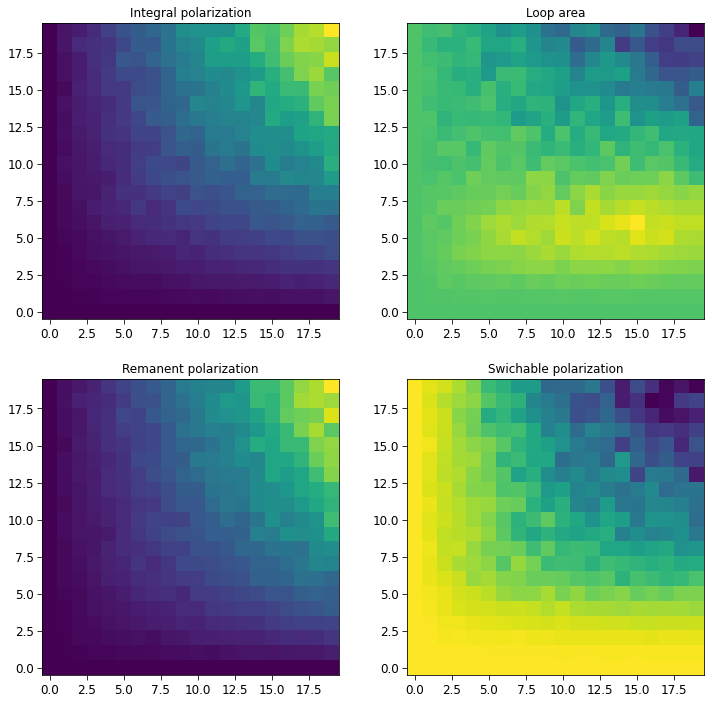

In [7]:
_, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0,0].imshow(results_arr[:,:,0],cmap='viridis', origin='lower')
ax[0,0].tick_params(labelsize=12, length=5)
ax[0,0].set_title('Integral polarization') 
ax[0,1].imshow(results_arr[:,:,1], cmap='viridis', origin='lower')
ax[0,1].tick_params(labelsize=12, length=5)
ax[0,1].set_title('Loop area')
ax[1,0].imshow(results_arr[:,:,2],cmap='viridis', origin='lower')
ax[1,0].tick_params(labelsize=12, length=5)
ax[1,0].set_title('Remanent polarization') 
ax[1,1].imshow(results_arr[:,:,3], cmap='viridis', origin='lower')
ax[1,1].tick_params(labelsize=12, length=5)
ax[1,1].set_title('Swichable polarization')
plt.show()

Let's now explore this response field using GP-based exploration-exploitation. First we define new objective functions that compute loop asymmetry and loop area.

In [8]:
def quality_func_2(input_arr):
    def_num, random_field = input_arr[0], input_arr[1]
    sim = Ferro2DSim(n=10, defect_number=def_num, rfield_strength=random_field, rTip=3)
    results = sim.runSim()
    st = (sim.results['Polarization'][500]+sim.results['Polarization'][250])/(sim.results['Polarization'][500]-sim.results['Polarization'][250])
    return st  

def quality_func_3(input_arr):
    def_num, random_field = input_arr[1], input_arr[0]
    sim = Ferro2DSim(n=10, defect_number=def_num, rfield_strength=random_field, rTip=3)
    results = sim.runSim()
    st = ((sim.results['Polarization'][375:625]-sim.results['Polarization'][125:375]).sum())/(100*250)
    return st  

Define custom acquisition functions for GP-based Bayesian optimization:

In [9]:
import random

def acq(gpmodel, X_full, X_sparse):  # leave it as is
    mean, sd = gpmodel.predict(X_full, verbose=0) # leave it as is
    acq = np.exp(-(mean-0.7)**2)
    return acq, (mean, sd)  # leave it as is


def acq2(gpmodel, X_full, X_sparse):  # leave it as is
    mean, sd = gpmodel.predict(X_full, verbose=0) # leave it as is
    random_bit = random.getrandbits(1)
    random_boolean = bool(random_bit)
    if random_boolean:
      acq = np.exp(-(mean-0.9)**2)
    else:
      acq = sd
    return acq, (mean, sd)  # leave it as is    

Create an empty grid and seed it with a few random observations:

In [10]:
size_def, size_field = 100, 100
Z_sparse = np.ones((size_def, size_field))*np.nan
idx = np.random.randint(0, Z_sparse.shape[0], size=(5, 2))
for i in idx:
    Z_sparse[i[0], i[1]] = quality_func_3([i[0], i[1]])

Run optimization:

In [11]:
# Get full and sparse grids
X_full = gpim.utils.get_full_grid(Z_sparse)
X_sparse= gpim.utils.get_sparse_grid(Z_sparse)
# Initialize Bayesian optimizer with a custom acquisition function
boptim = gpim.boptimizer(
    X_sparse, Z_sparse, X_full, 
    quality_func_3, acquisition_function=acq2,  # added custom acquisition function
    exploration_steps=100, dscale=4, batch_size=5000, exit_strategy=1,
    use_gpu=False, verbose=1)
# Run Bayesian optimization
boptim.run()


Exploration step 1 / 100
Model training...
average time per iteration: 0.0038 s
training completed in 2.85 s
Final parameter values:
 amp: 0.3404, lengthscale: [49.9806 49.9672], noise: 8.67e-05
Computing acquisition function...
Model training...
average time per iteration: 0.0028000000000000004 s
training completed in 2.71 s
Final parameter values:
 amp: 0.2838, lengthscale: [49.9999 49.9999], noise: 2e-07

Exploration step 2 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.0027 s
training completed in 2.7 s
Final parameter values:
 amp: 0.248, lengthscale: [50. 50.], noise: 0.0

Exploration step 3 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.0029 s
training completed in 2.81 s
Final parameter values:
 amp: 0.2364, lengthscale: [50. 50.], noise: 0.0

Exploration step 4 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.0028000000000000004 s
training completed in 2.79

Model training...
average time per iteration: 0.0028000000000000004 s
training completed in 2.78 s
Final parameter values:
 amp: 0.1656, lengthscale: [50. 50.], noise: 2.01e-05

Exploration step 38 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.0028000000000000004 s
training completed in 3.0 s
Final parameter values:
 amp: 0.1677, lengthscale: [50. 50.], noise: 1.9e-05

Exploration step 39 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.003 s
training completed in 3.03 s
Final parameter values:
 amp: 0.1703, lengthscale: [50. 50.], noise: 1.79e-05

Exploration step 40 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.003 s
training completed in 2.94 s
Final parameter values:
 amp: 0.1648, lengthscale: [50. 50.], noise: 1.83e-05

Exploration step 41 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.0029 s
training completed in 2.91 

Model training...
average time per iteration: 0.0032 s
training completed in 3.13 s
Final parameter values:
 amp: 0.1343, lengthscale: [50. 50.], noise: 2.88e-05

Exploration step 75 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.0036 s
training completed in 3.46 s
Final parameter values:
 amp: 0.1349, lengthscale: [50. 50.], noise: 2.85e-05

Exploration step 76 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.0037 s
training completed in 3.44 s
Final parameter values:
 amp: 0.1351, lengthscale: [50. 50.], noise: 2.8e-05

Exploration step 77 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.0034999999999999996 s
training completed in 3.37 s
Final parameter values:
 amp: 0.1344, lengthscale: [50. 50.], noise: 2.83e-05

Exploration step 78 / 100
Computing acquisition function...
Model training...
average time per iteration: 0.0036 s
training completed in 3.6 s
Final param

Plot results at different steps of the optimization:

Step 1


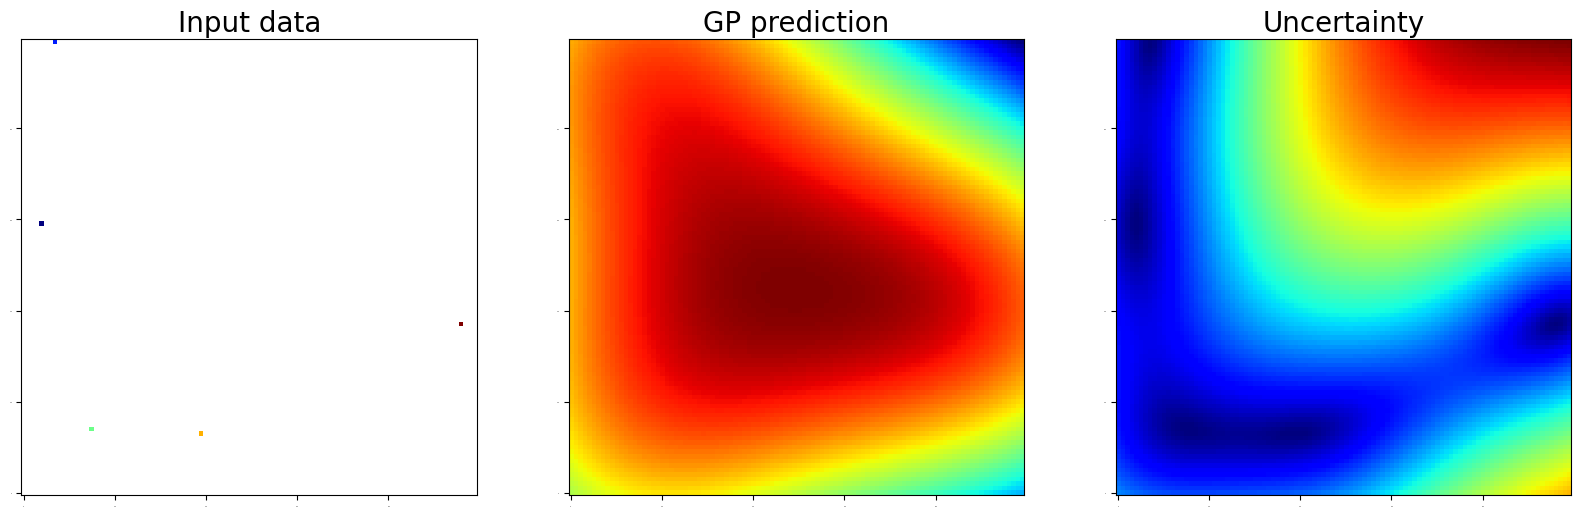

Step 6


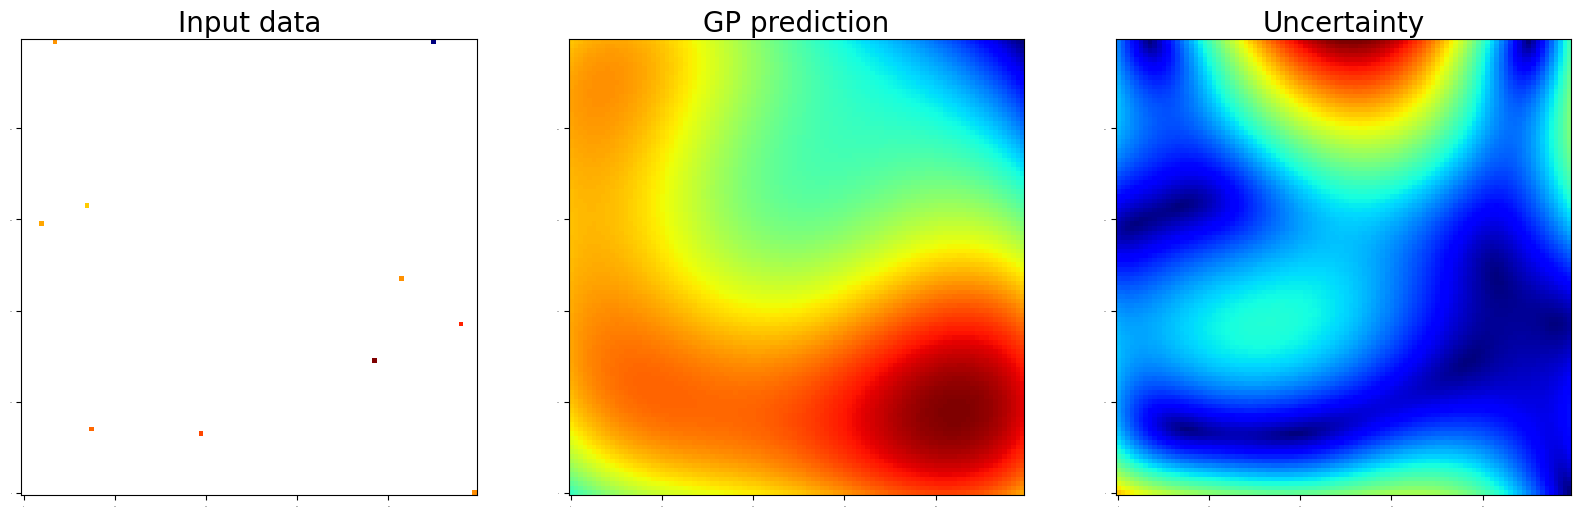

Step 11


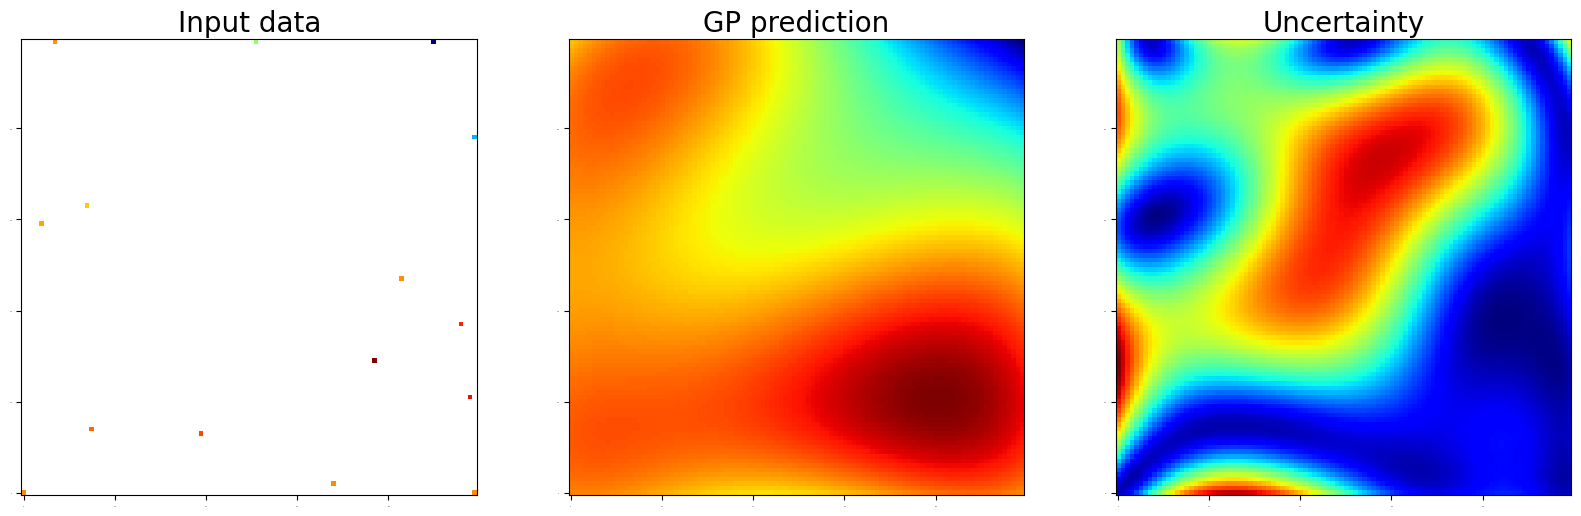

Step 16


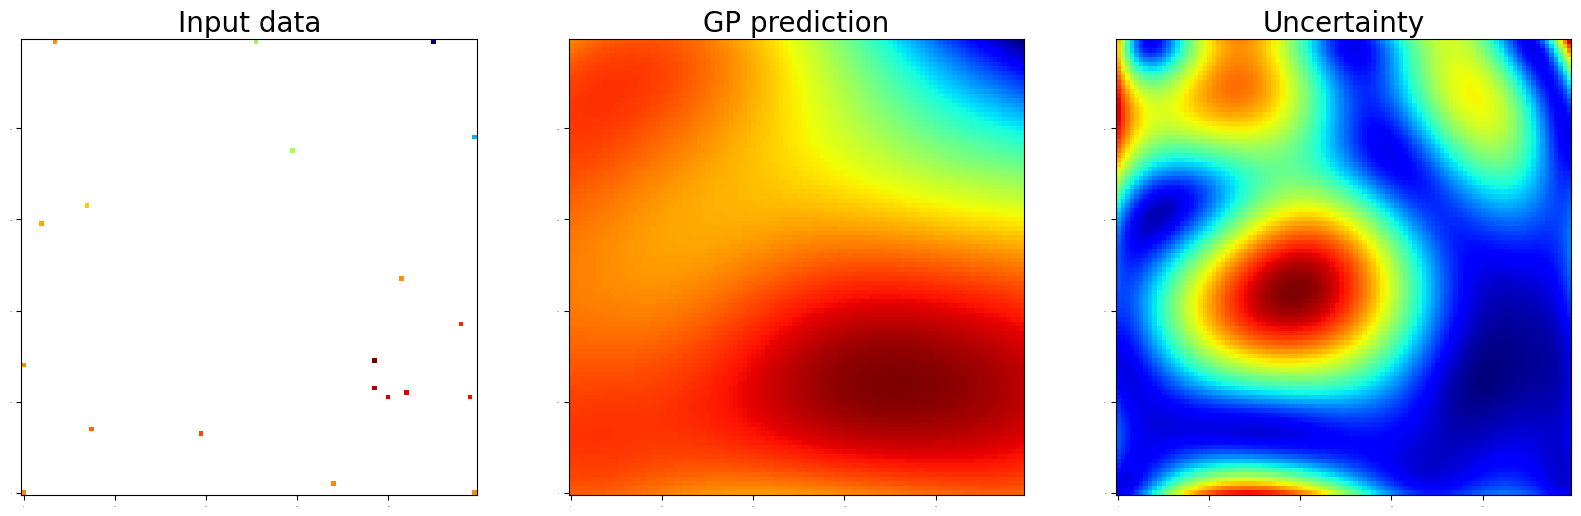

Step 21


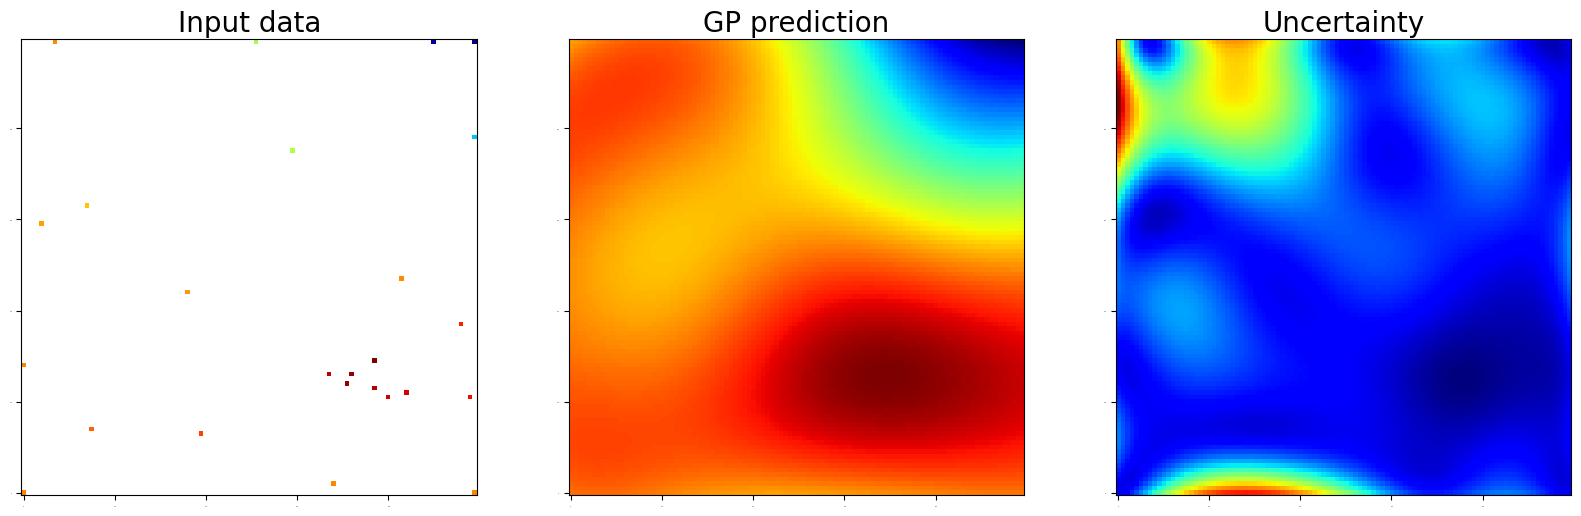

Step 26


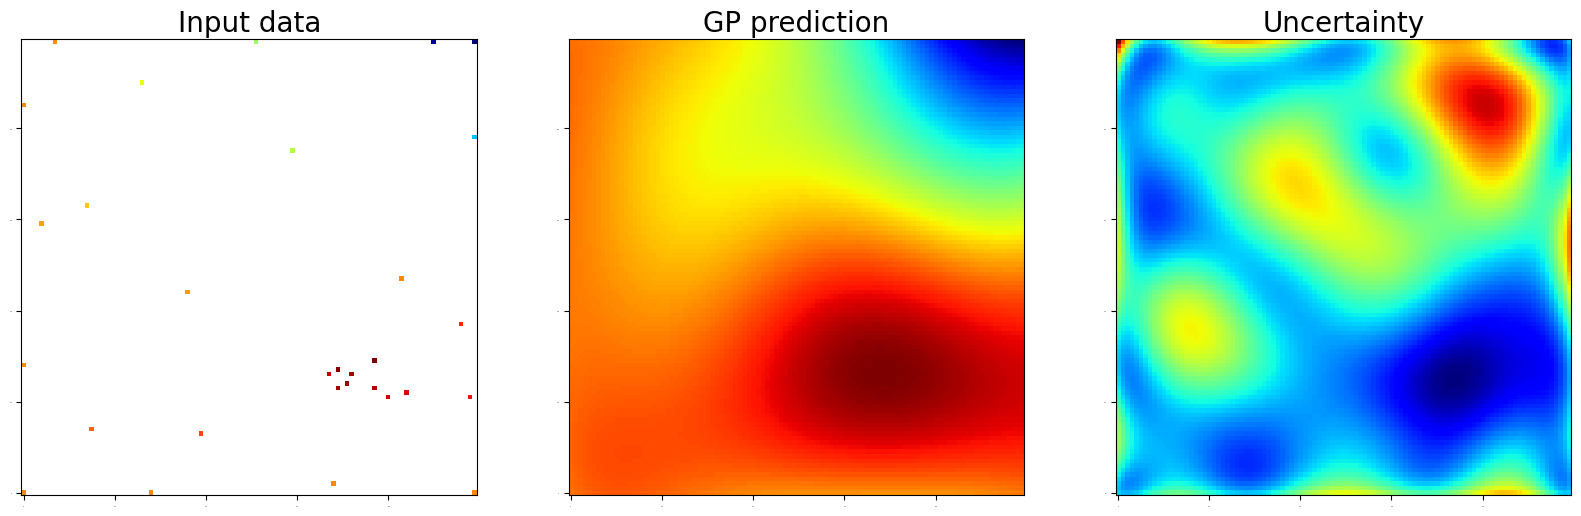

Step 31


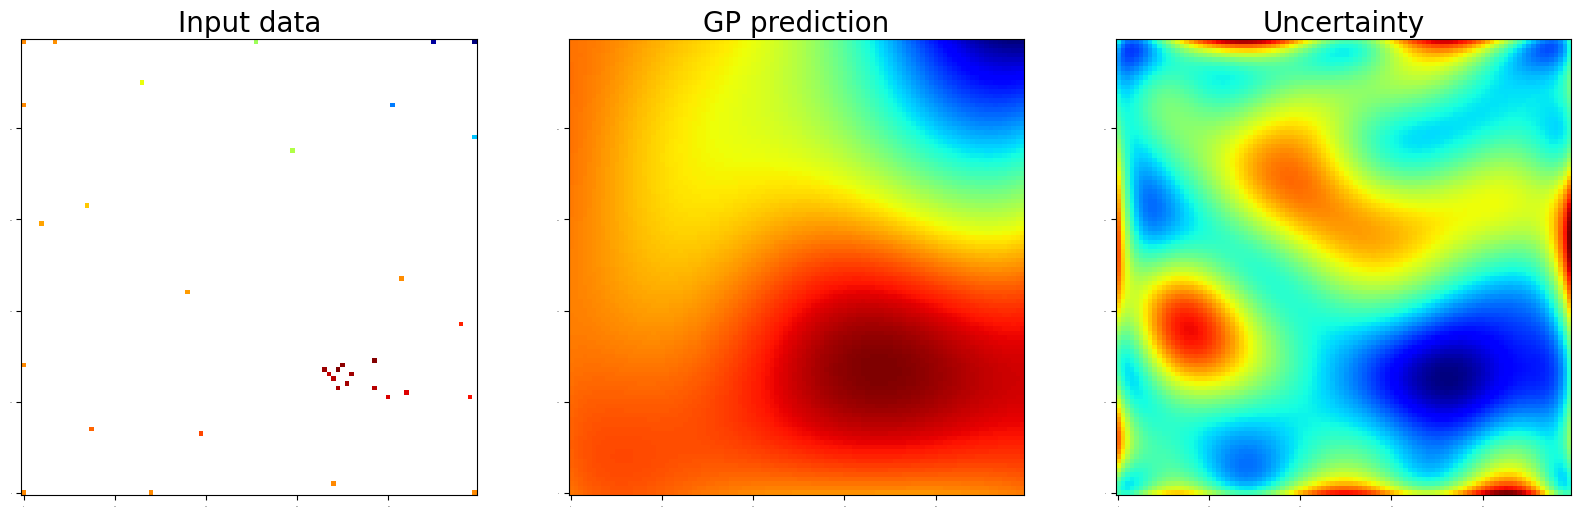

Step 36


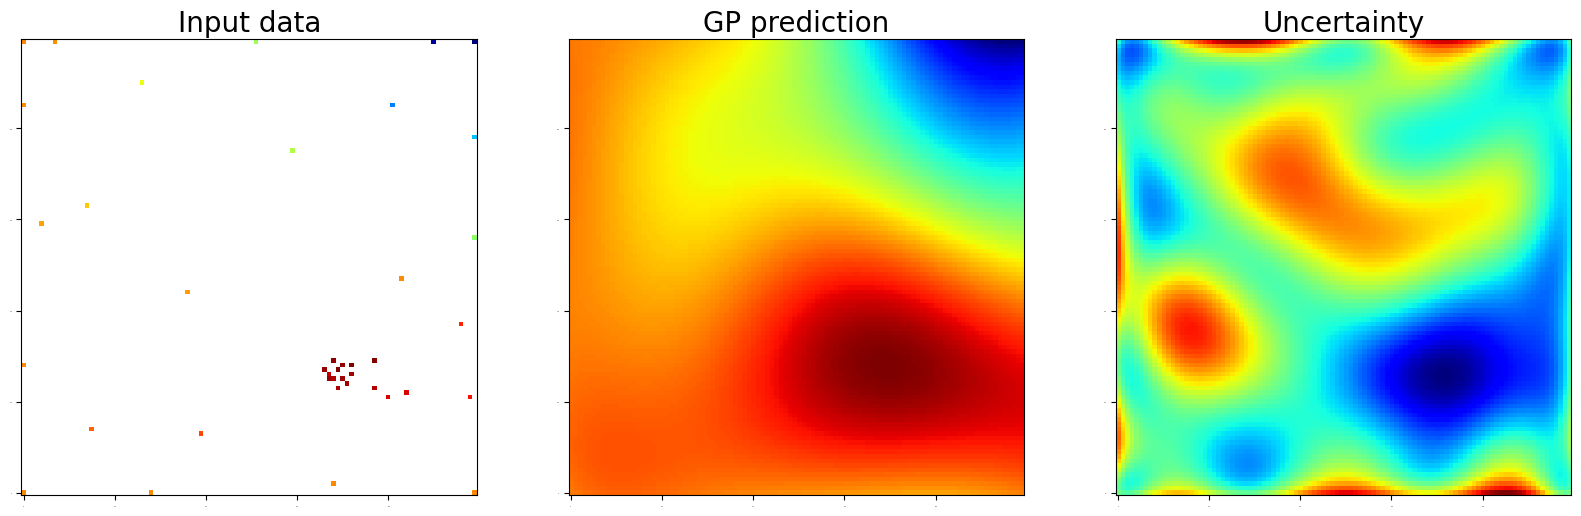

Step 41


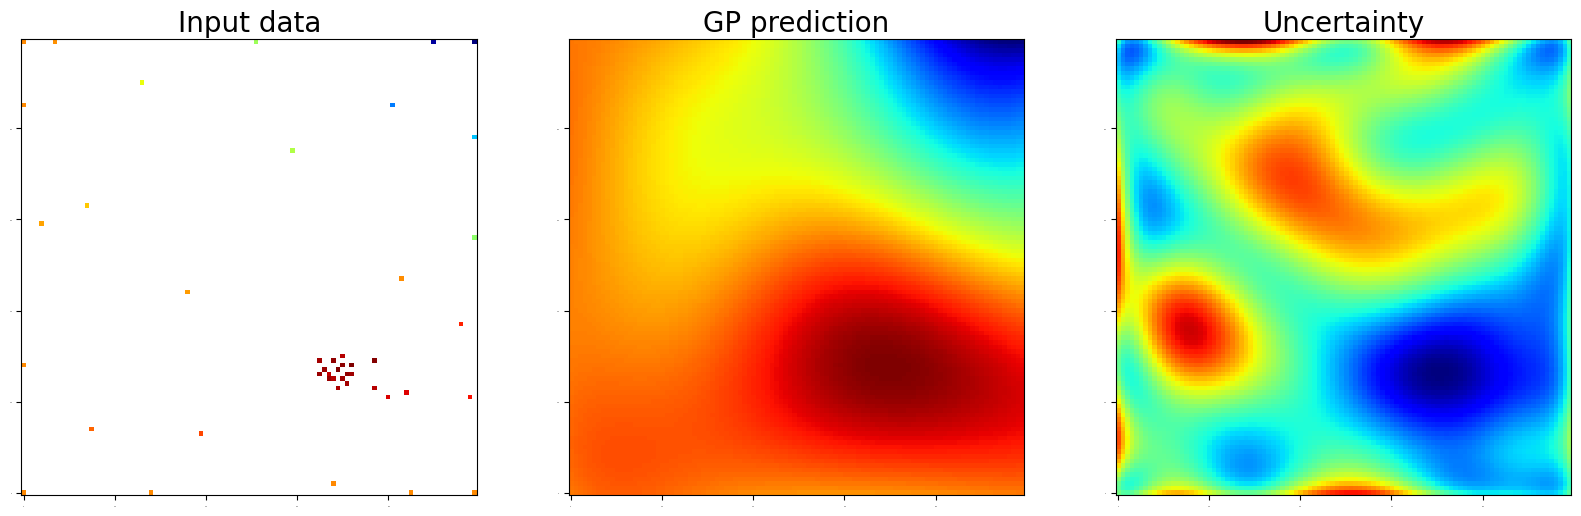

Step 46


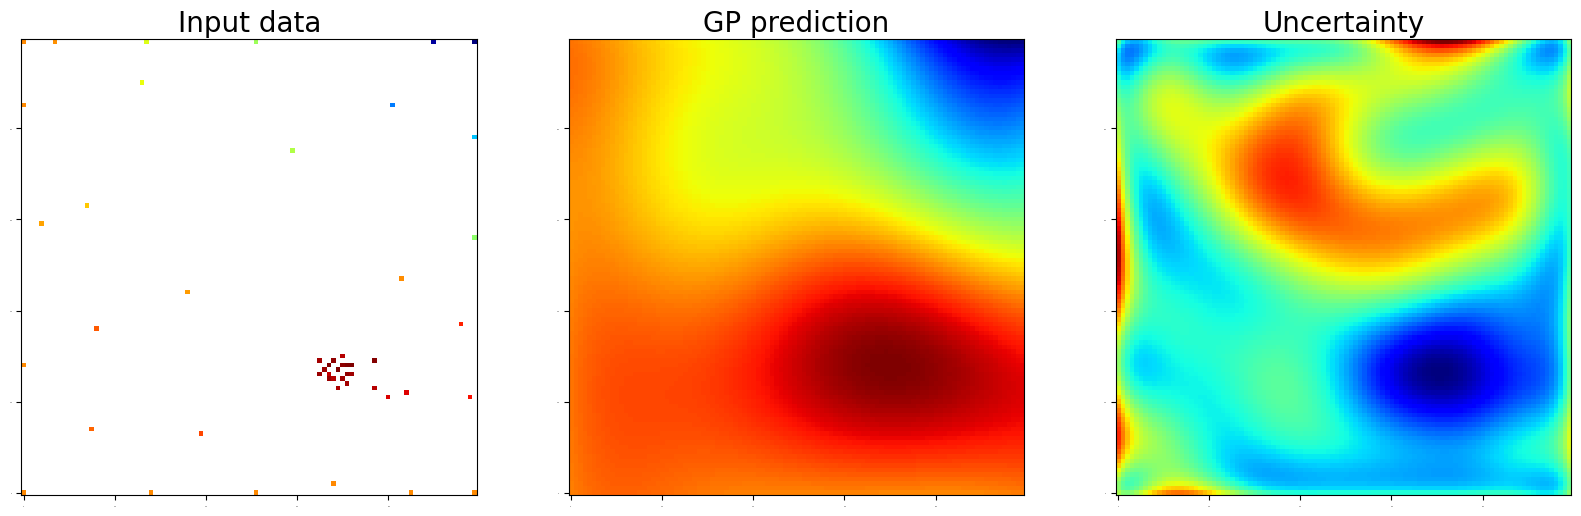

Step 51


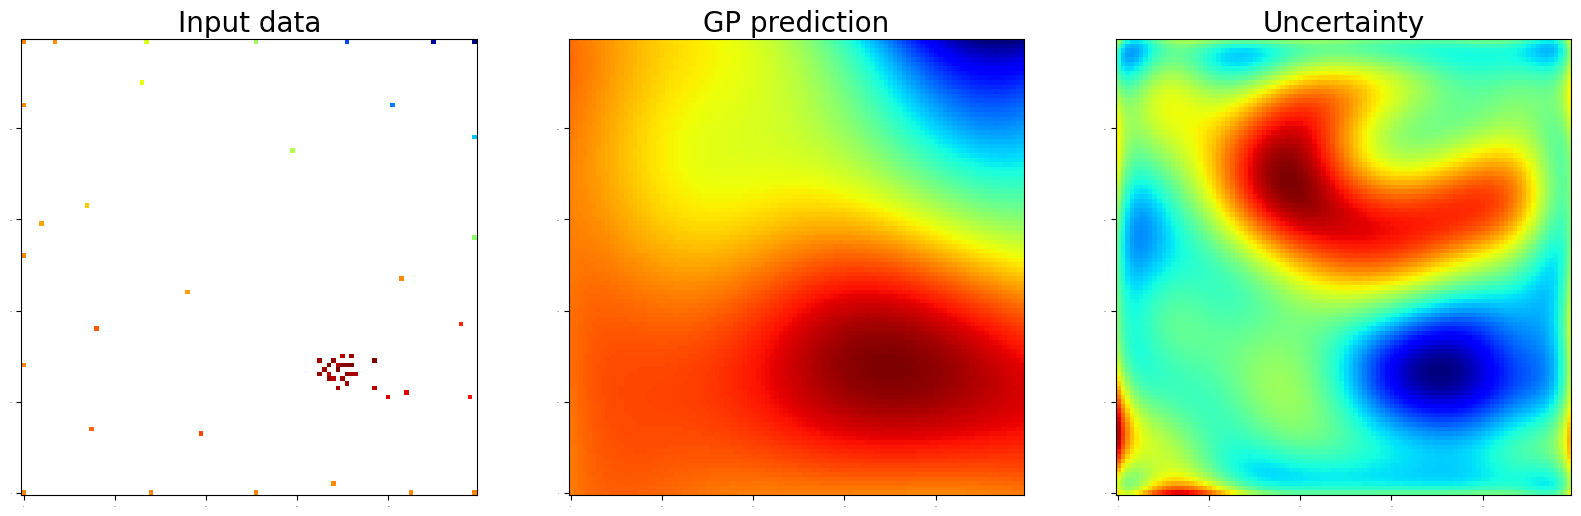

Step 56


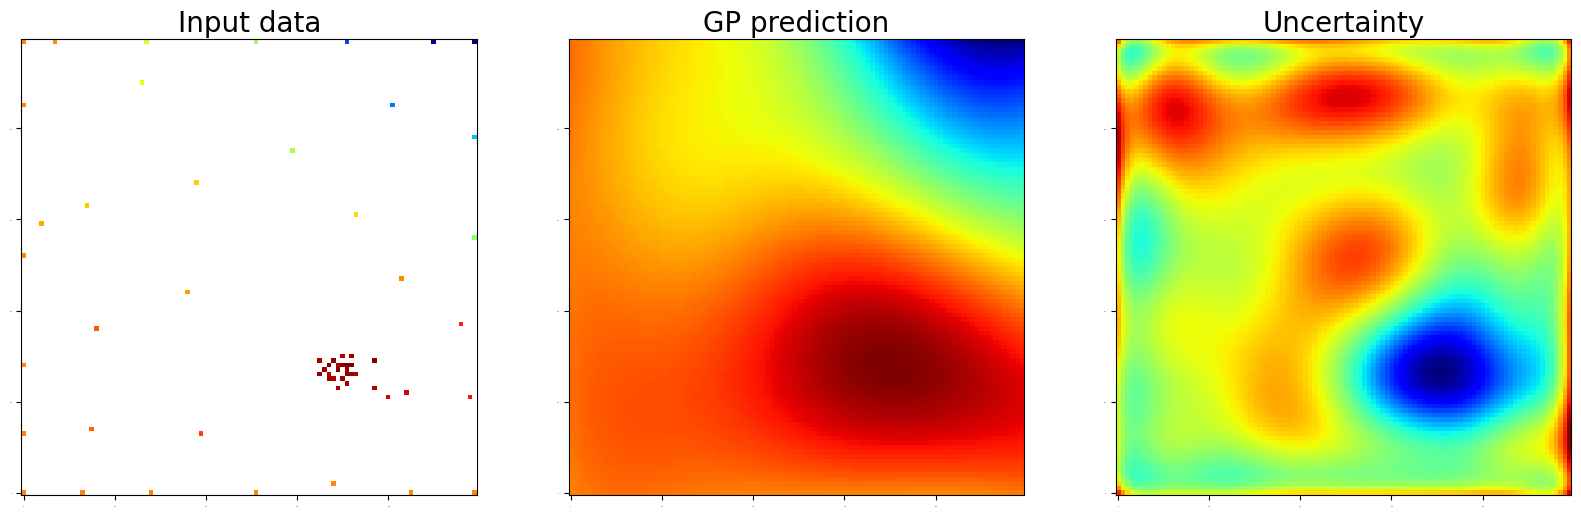

Step 61


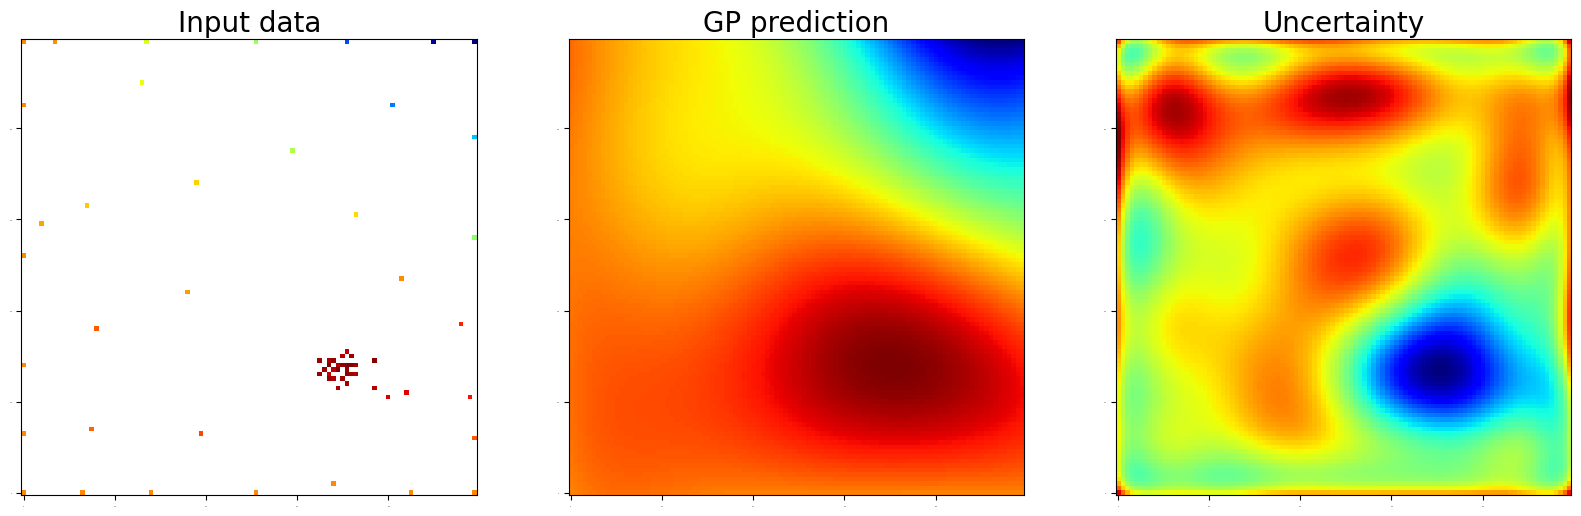

Step 66


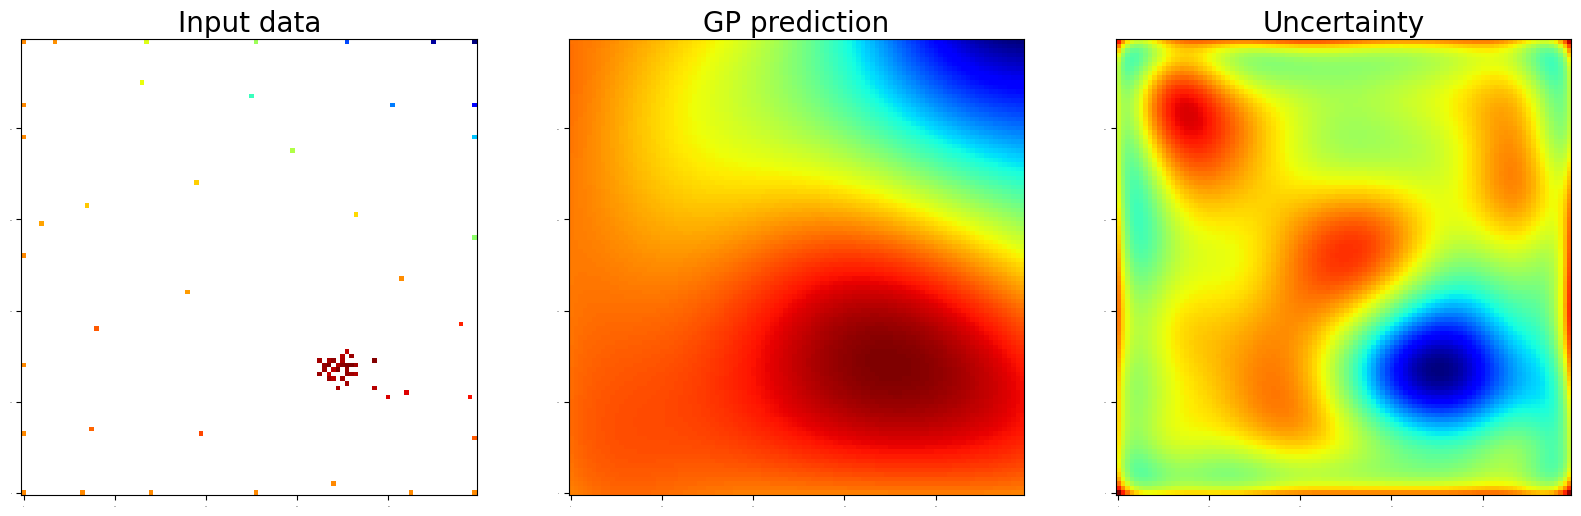

Step 71


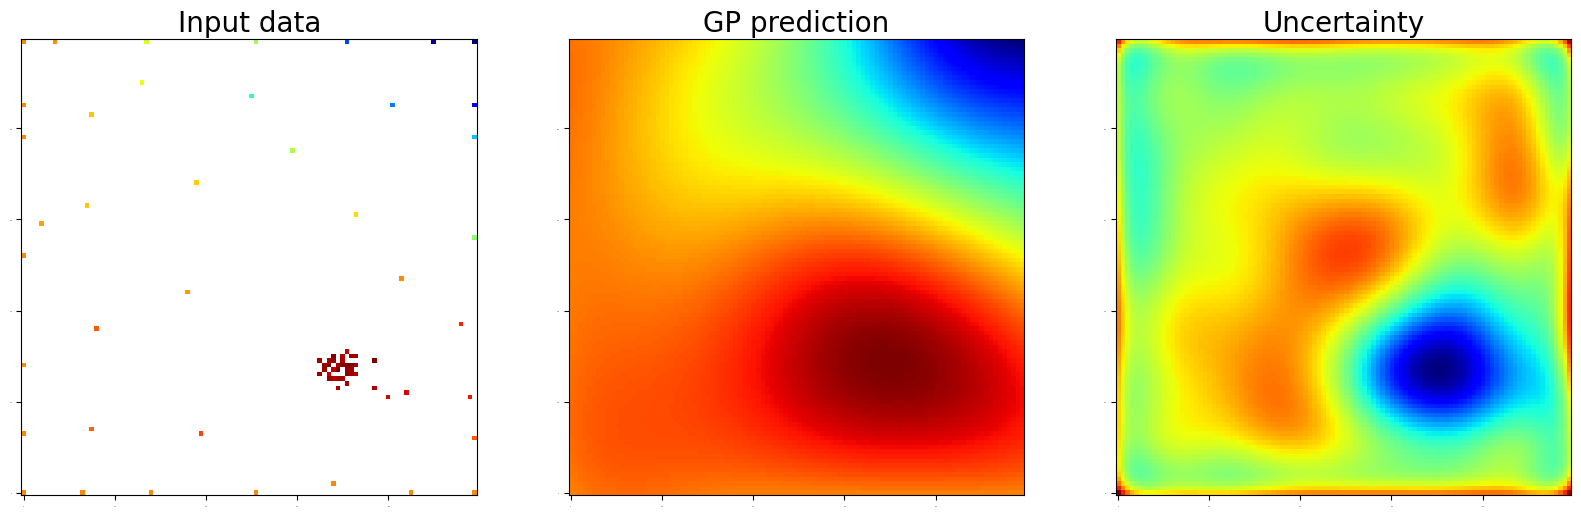

Step 76


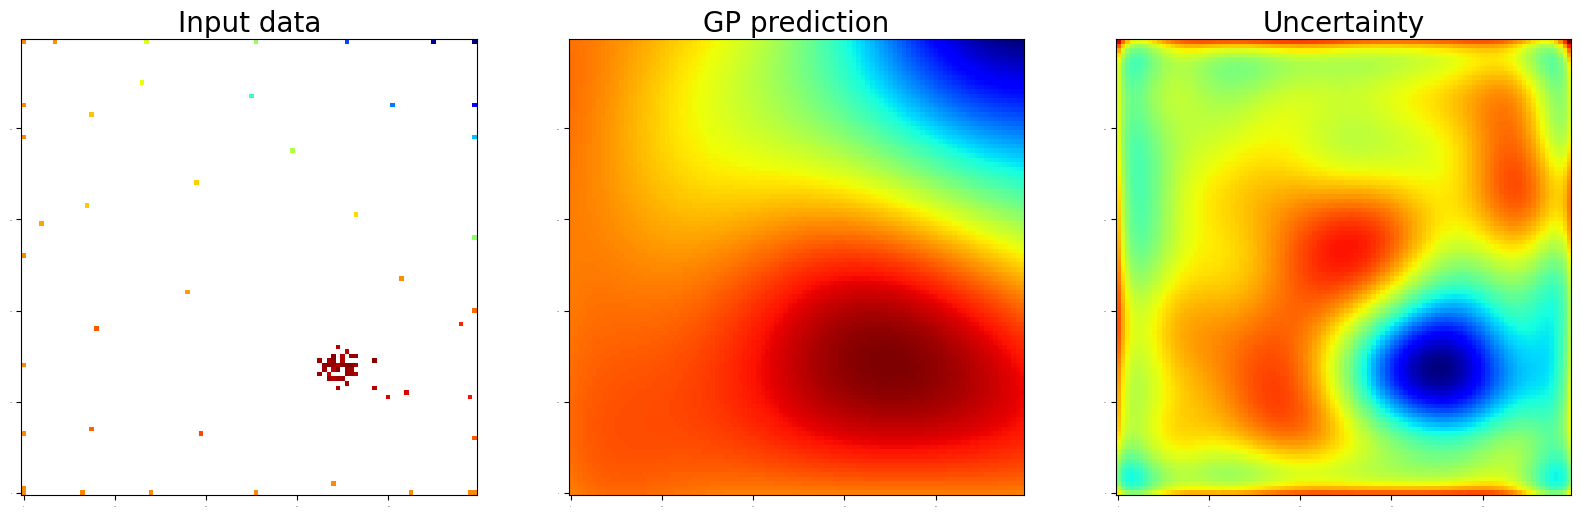

Step 81


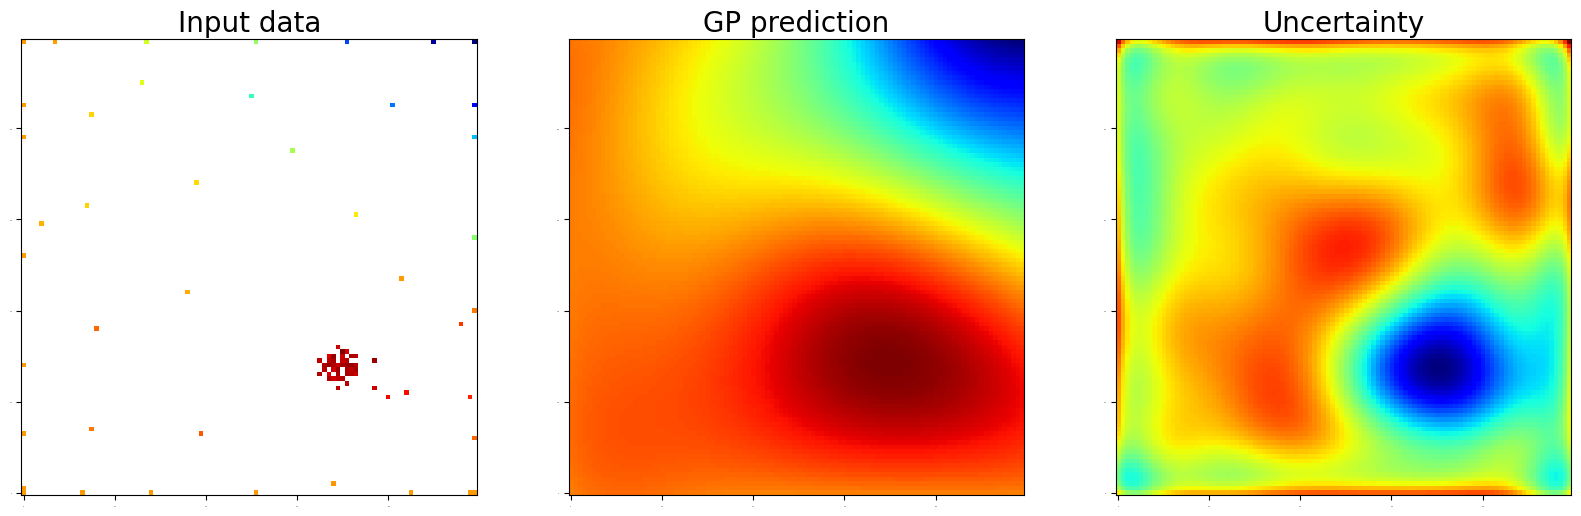

Step 86


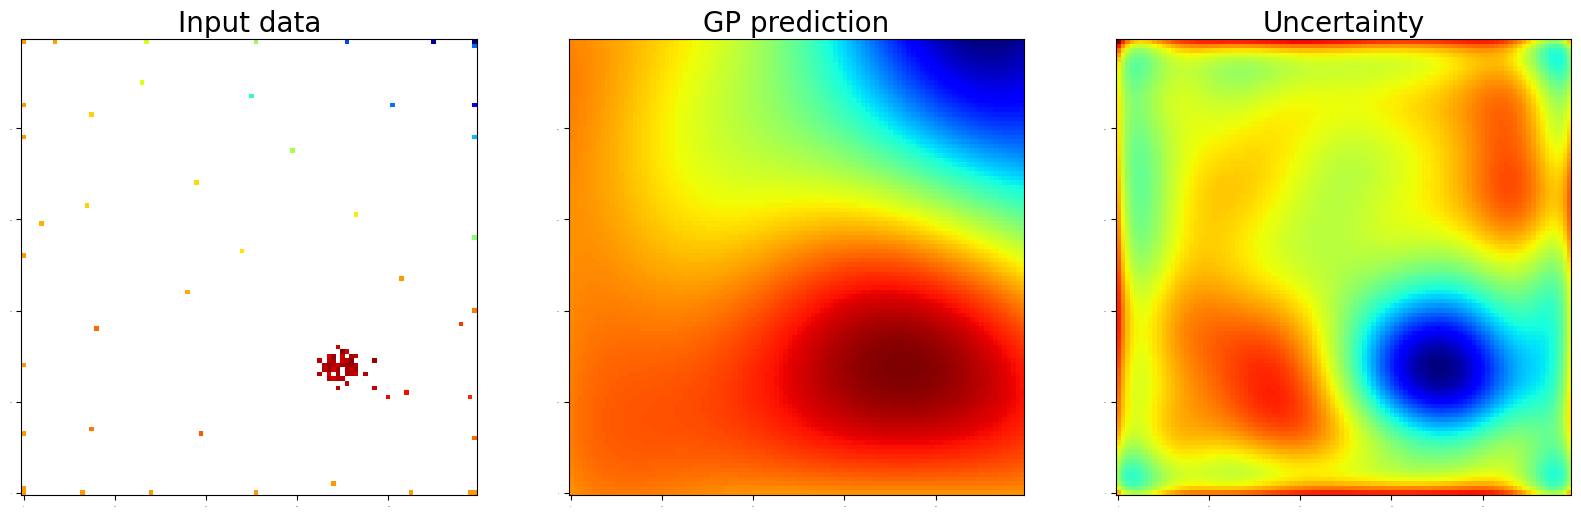

Step 91


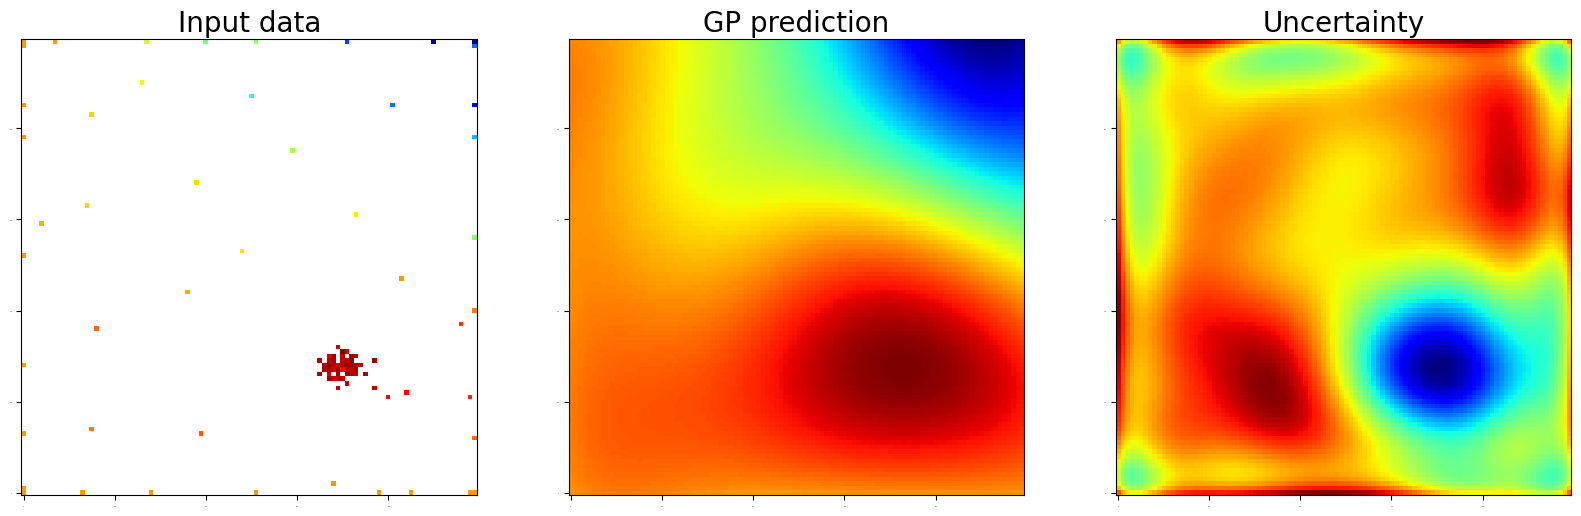

Step 96


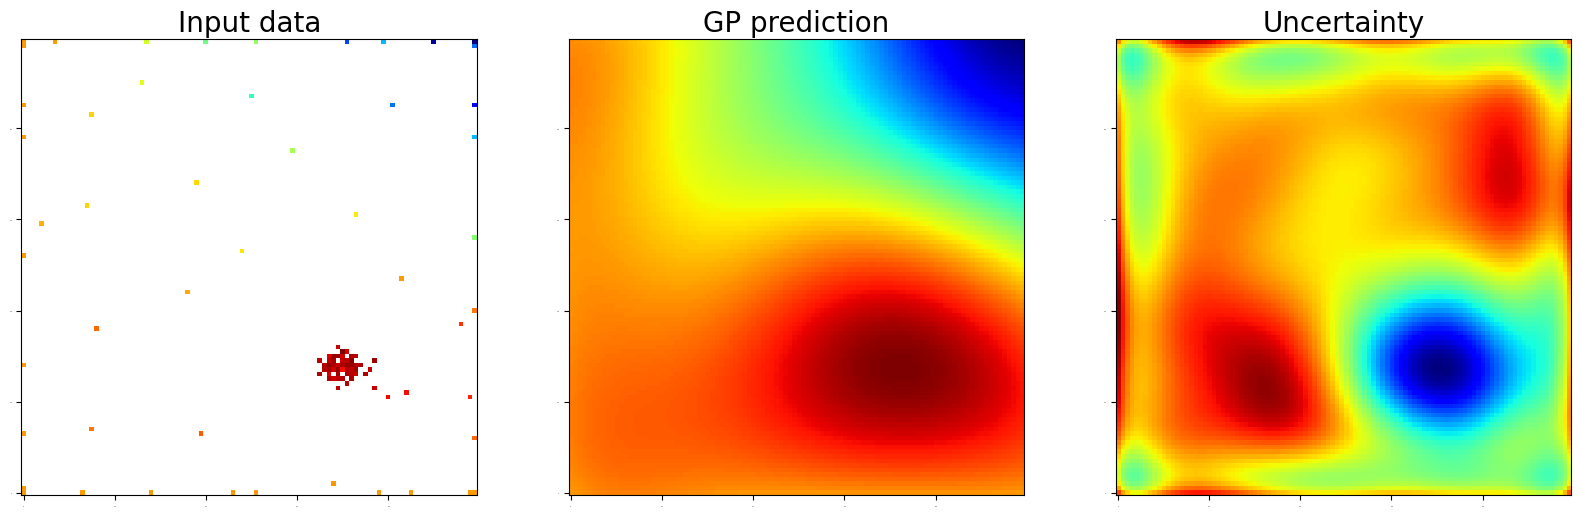

In [12]:
#def plot_exploration_results()
for i, (func, pred) in enumerate(zip(boptim.target_func_vals, boptim.gp_predictions)):
  if i % 5 == 0:
    print('Step {}'.format(i+1))
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 12), dpi=100)
    ax1.imshow(func, cmap='jet', origin='lower')
    ax1.tick_params(labelsize = 0)
    ax2.imshow(pred[0], cmap='jet', origin='lower')
    ax2.tick_params(labelsize = 0)
    ax3.imshow(pred[1], cmap='jet', origin='lower')
    ax3.tick_params(labelsize = 0)
    ax1.set_title('Input data', size = 20)
    ax2.set_title('GP prediction', size = 20)
    ax3.set_title('Uncertainty', size = 20)
    plt.show()

Plot exploration history:

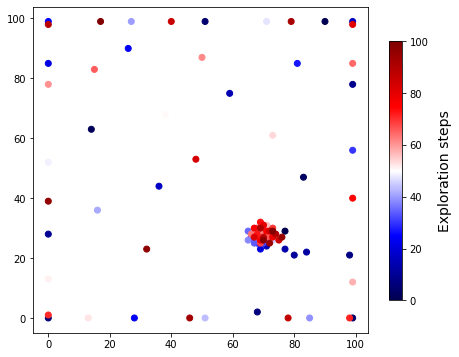

In [13]:
gpim.utils.plot_query_points(boptim.indices_all, cmap='seismic', plot_lines=False)